## Inżynieria cech

Łączna liczba zdjęć w zbiorze treningowym: 1764
Łączna liczba zdjęć w zbiorze testowym: 74
Łączna liczba zdjęć w zbiorze walidacyjnym: 74


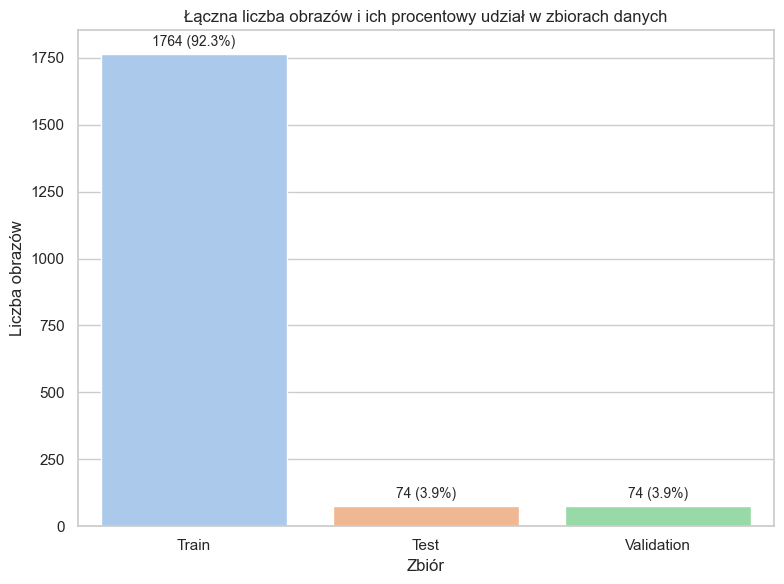

In [17]:
# Liczenie łącznej liczby zdjęć w każdym zbiorze - bez podzialu na klasy
# Liczenie łącznej liczby zdjęć w każdym zbiorze
# Ścieżka główna do folderu DATA
data_path = 'DATA\\'

# Stworzenie listy dla zbiorów Train, Test, Valid
train_path = os.path.join(data_path, 'Train_Test_Valid', 'Train')
test_path = os.path.join(data_path, 'Train_Test_Valid', 'test')
valid_path = os.path.join(data_path, 'Train_Test_Valid', 'valid')

# Lista klas (typów meduz)
classes = ['barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 
           'lions_mane_jellyfish', 'mauve_stinger_jellyfish', 'Moon_jellyfish']

# Przygotowanie listy plików dla każdej klasy i zbioru (Train, Test, Valid)
train_files = {cls: glob.glob(os.path.join(train_path, cls, '*.jpg')) for cls in classes}
test_files = {cls: glob.glob(os.path.join(test_path, cls, '*.jpg')) for cls in classes}
valid_files = {cls: glob.glob(os.path.join(valid_path, cls, '*.jpg')) for cls in classes}

def total_images_in_dataset(files_dict):
    return sum(len(paths) for paths in files_dict.values())

train_total = total_images_in_dataset(train_files)
test_total = total_images_in_dataset(test_files)
valid_total = total_images_in_dataset(valid_files)
total_all = train_total + test_total + valid_total

print("Łączna liczba zdjęć w zbiorze treningowym:", train_total)
print("Łączna liczba zdjęć w zbiorze testowym:", test_total)
print("Łączna liczba zdjęć w zbiorze walidacyjnym:", valid_total)

total_all = train_total + test_total + valid_total

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({
    'Zbiór': ['Train', 'Test', 'Validation'],
    'Liczba obrazów': [train_total, test_total, valid_total],
})

df['% całości'] = df['Liczba obrazów'] / total_all * 100

plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Zbiór', y='Liczba obrazów', hue='Zbiór', palette='pastel', legend=False)

for i, row in df.iterrows():
    plt.text(i, row['Liczba obrazów'] + total_all * 0.01, 
             f"{row['Liczba obrazów']} ({row['% całości']:.1f}%)", 
             ha='center', va='bottom', fontsize=10)

plt.title('Łączna liczba obrazów i ich procentowy udział w zbiorach danych')
plt.tight_layout()
plt.show()


Przetwarzanie obrazów: 100%|██████████| 956/956 [00:11<00:00, 85.98it/s]

📊 Statystyki zbioru (bez podziału na klasy):


,width,height,aspect_ratio,brightness,unique_colors,blur,pixel_mean
count,956.000000,956.000000,956.0,956.000000,956.000000,956.000000,956.000000
mean,211.620293,211.620293,1.0,86.383785,6070.489540,1676.489514,88.581770
std,20.106032,20.106032,0.0,42.036301,1835.821308,1614.476292,40.240873
min,179.000000,179.000000,1.0,6.755401,1537.000000,21.866674,8.375664
25%,179.000000,179.000000,1.0,51.276223,4700.500000,625.462271,56.094659
50%,224.000000,224.000000,1.0,83.532435,5975.000000,1192.091678,86.230407
75%,224.000000,224.000000,1.0,117.254439,7379.250000,2152.679158,117.026391
max,224.000000,224.000000,1.0,226.297473,9902.000000,12035.001968,225.638180


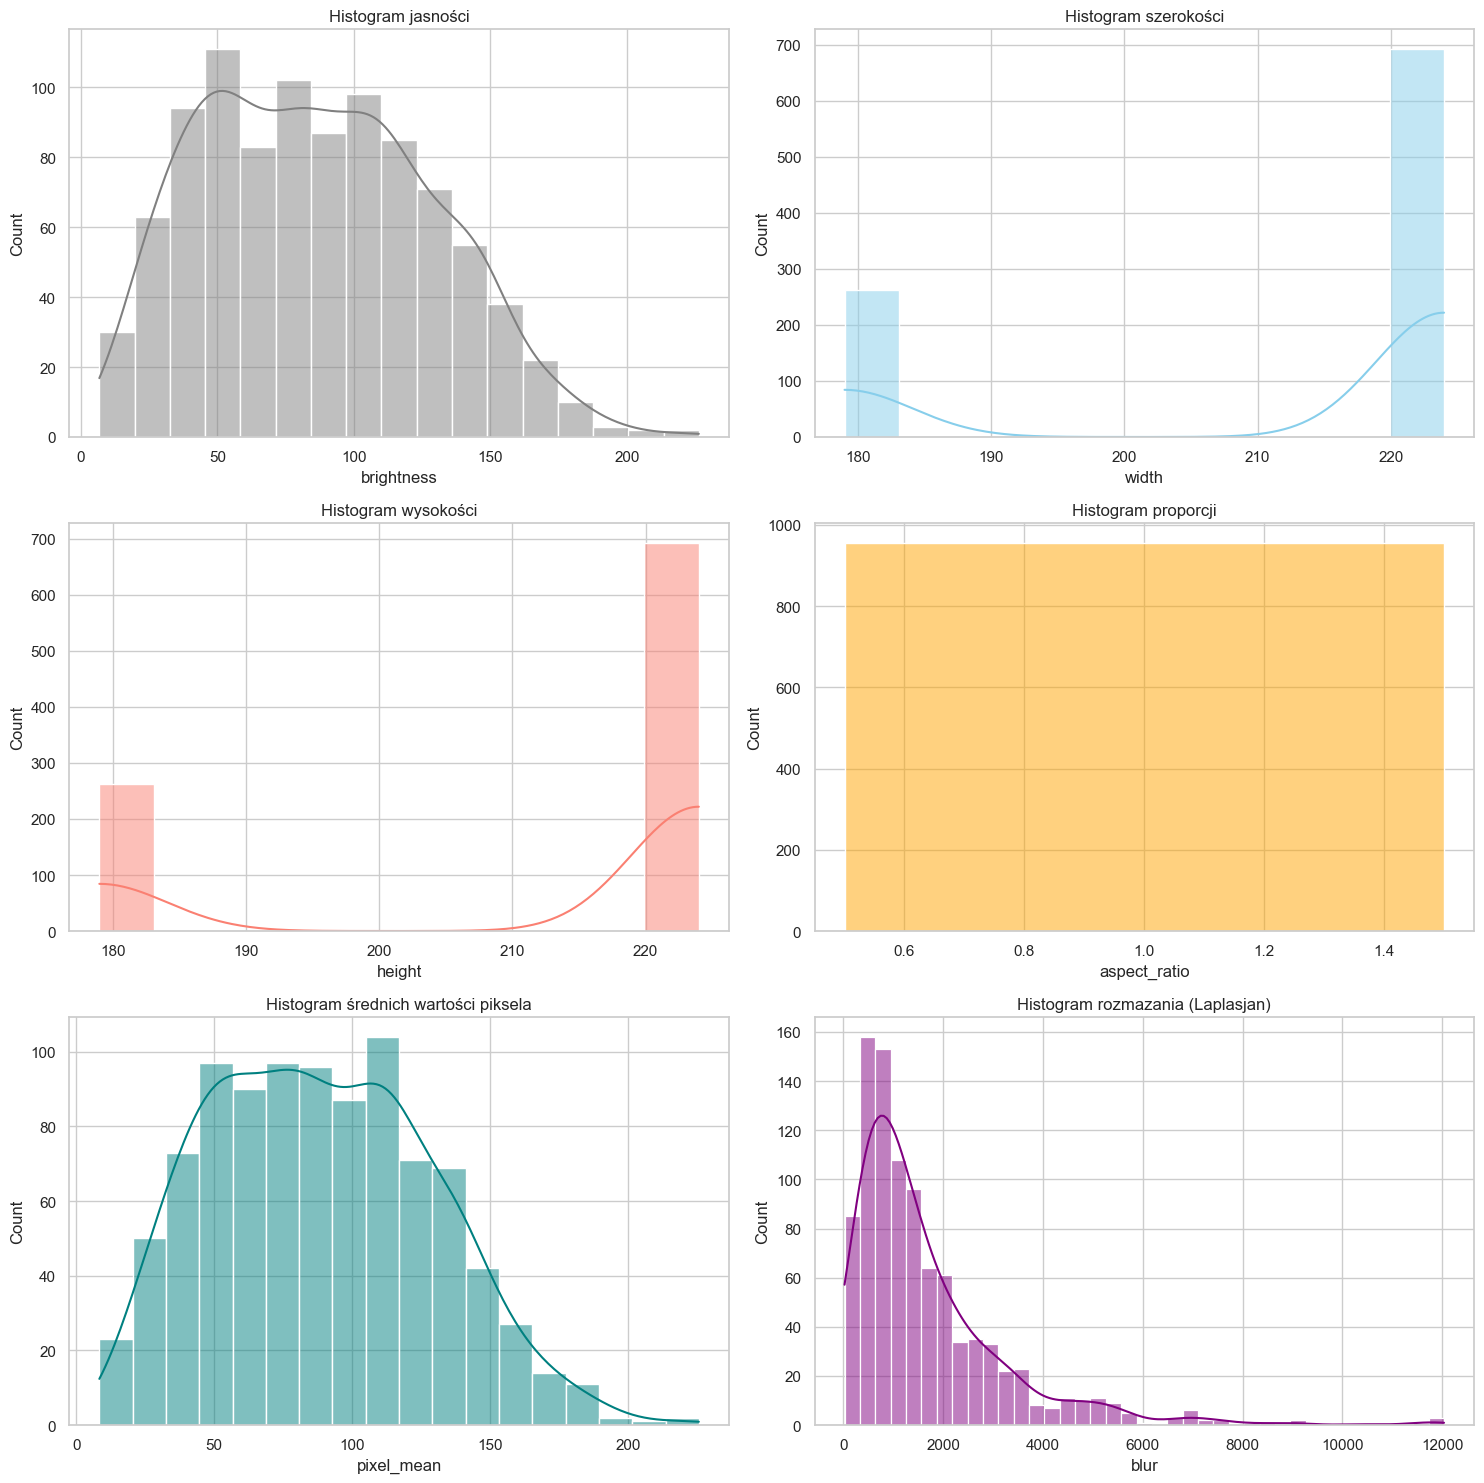

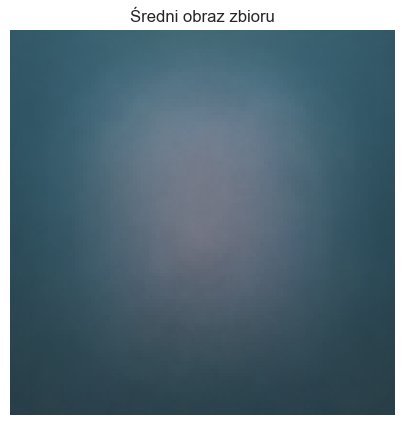

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

# Ścieżki do folderów
train_path = 'DATA/Backup/Train'
test_path = 'DATA/Backup/Test'
valid_path = 'DATA/Backup/Valid'

# Zbieramy wszystkie pliki .jpg w podkatalogach dla wszystkich trzech zbiorów
image_paths = glob.glob(os.path.join(train_path, '**', '*.jpg'), recursive=True) + \
              glob.glob(os.path.join(test_path, '**', '*.jpg'), recursive=True) + \
              glob.glob(os.path.join(valid_path, '**', '*.jpg'), recursive=True)

# Inicjalizacja
widths, heights, aspect_ratios = [], [], []
brightness_vals, unique_colors, blur_vals = [], [], []
pixel_means = []
hue_hist_total = np.zeros((180, 1))
avg_image = None

# Przetwarzanie obrazów
for path in tqdm(image_paths, desc="Przetwarzanie obrazów"):
    img = cv2.imread(str(path))
    if img is None:
        print(f"Nie można wczytać obrazu: {path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(w / h)
    brightness_vals.append(np.mean(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)))

    # Średnia wartość piksela (dla RGB razem)
    pixel_means.append(np.mean(img))

    # Histogram Hue
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue_hist_total += cv2.calcHist([hsv], [0], None, [180], [0, 180])

    # Średni obraz (przeskalowany)
    img_resized = cv2.resize(img, (100, 100))
    if avg_image is None:
        avg_image = np.zeros_like(img_resized, dtype=np.float64)
    avg_image += img_resized / len(image_paths)

    # Unikalne kolory
    unique_colors.append(len(np.unique(img_resized.reshape(-1, 3), axis=0)))

    # Rozmazanie
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    blur_vals.append(cv2.Laplacian(gray, cv2.CV_64F).var())

# Przekształć średni obraz
avg_image = avg_image.astype(np.uint8)
hue_hist_total /= len(image_paths)

# Tworzymy ramkę danych i statystyki
df = pd.DataFrame({
    'width': widths,
    'height': heights,
    'aspect_ratio': aspect_ratios,
    'brightness': brightness_vals,
    'unique_colors': unique_colors,
    'blur': blur_vals,
    'pixel_mean': pixel_means
})

# Statystyki zbioru
print("📊 Statystyki zbioru (bez podziału na klasy):")
display(df.describe())

# Wykresy
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 6 wykresów = 3x2

sns.histplot(df['brightness'], kde=True, ax=axes[0, 0], color='gray').set_title('Histogram jasności')
sns.histplot(df['width'], kde=True, ax=axes[0, 1], color='skyblue').set_title('Histogram szerokości')
sns.histplot(df['height'], kde=True, ax=axes[1, 0], color='salmon').set_title('Histogram wysokości')
sns.histplot(df['aspect_ratio'], kde=True, ax=axes[1, 1], color='orange').set_title('Histogram proporcji')
sns.histplot(df['pixel_mean'], kde=True, ax=axes[2, 0], color='teal').set_title('Histogram średnich wartości piksela')
sns.histplot(df['blur'], kde=True, ax=axes[2, 1], color='purple').set_title('Histogram rozmazania (Laplasjan)')

plt.tight_layout()
plt.show()

# Średni obraz
plt.figure(figsize=(5, 5))
plt.imshow(avg_image)
plt.title("Średni obraz zbioru")
plt.axis('off')
plt.show()


In [ ]:
#Zmiana rozmiaru wszystkich zdjęć do 224x224 oraz ich standaryzacja z-score
#Standaryzacja: (img - mean) / std przekształca wartości do rozkładu Z-score, gdzie średnia to 0, a odchylenie standardowe to 1.
#Przywracanie wartości do zakresu 0–255 po standaryzacji jest konieczne, 
#ponieważ standardowe obrazy muszą mieć piksele w tym zakresie, aby mogły być poprawnie zapisane i wyświetlone. 


import os
from pathlib import Path


# Ścieżki wejściowe i wyjściowe
input_base = Path("DATA/Train_Test_Valid")
output_base = Path("DATA/Standardized_Resized")

# Tworzenie katalogu wyjściowego jeśli nie istnieje
output_base.mkdir(parents=True, exist_ok=True)

# Przetwarzanie zbiorów
for subset in ['Train', 'Test', 'Valid']:
    input_subset = input_base / subset
    output_subset = output_base / subset
    image_paths = list(input_subset.rglob("*.jpg"))

    print(f"\n📁 Przetwarzanie zbioru: {subset} ({len(image_paths)} obrazów)")

    for img_path in tqdm(image_paths):
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"⚠️ Nie można wczytać: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Standaryzacja Z-score
        mean = np.mean(img, axis=(0, 1), keepdims=True)
        std = np.std(img, axis=(0, 1), keepdims=True) + 1e-8  # by uniknąć dzielenia przez 0
        img_std = (img - mean) / std

        # Zmiana rozmiaru na 224x224
        img_resized = cv2.resize(img_std, (224, 224), interpolation=cv2.INTER_LINEAR)

        # Konwersja do 0–255 i uint8 dla zapisu
        img_scaled = np.clip(((img_resized - img_resized.min()) / (img_resized.max() - img_resized.min())) * 255, 0, 255).astype(np.uint8)
        img_bgr = cv2.cvtColor(img_scaled, cv2.COLOR_RGB2BGR)

        # Ścieżka wyjściowa
        relative_path = img_path.relative_to(input_base)
        output_path = output_base / relative_path
        output_path.parent.mkdir(parents=True, exist_ok=True)

        cv2.imwrite(str(output_path), img_bgr)




📁 Przetwarzanie zbioru: Train (1764 obrazów)


100%|██████████| 1764/1764 [00:13<00:00, 129.66it/s]



📁 Przetwarzanie zbioru: Test (74 obrazów)


100%|██████████| 74/74 [00:00<00:00, 109.42it/s]



📁 Przetwarzanie zbioru: Valid (74 obrazów)


100%|██████████| 74/74 [00:00<00:00, 103.54it/s]


Przetwarzanie obrazów: 100%|██████████| 1912/1912 [00:21<00:00, 88.40it/s]

📊 Statystyki zbioru (bez podziału na klasy):


,width,height,aspect_ratio,brightness,unique_colors,blur,pixel_mean
count,1912.0,1912.0,1912.0,1912.000000,1912.000000,1912.000000,1912.000000
mean,224.0,224.0,1.0,88.610538,6245.023536,902.924371,88.605001
std,0.0,0.0,0.0,39.279203,1767.594322,808.233621,39.283068
min,224.0,224.0,1.0,5.932936,1813.000000,79.018241,6.082217
25%,224.0,224.0,1.0,55.283921,4873.750000,385.723765,55.301560
50%,224.0,224.0,1.0,90.307956,6235.500000,660.431090,90.316297
75%,224.0,224.0,1.0,118.042236,7589.500000,1147.217936,118.046259
max,224.0,224.0,1.0,218.598473,9871.000000,6519.444558,218.612723


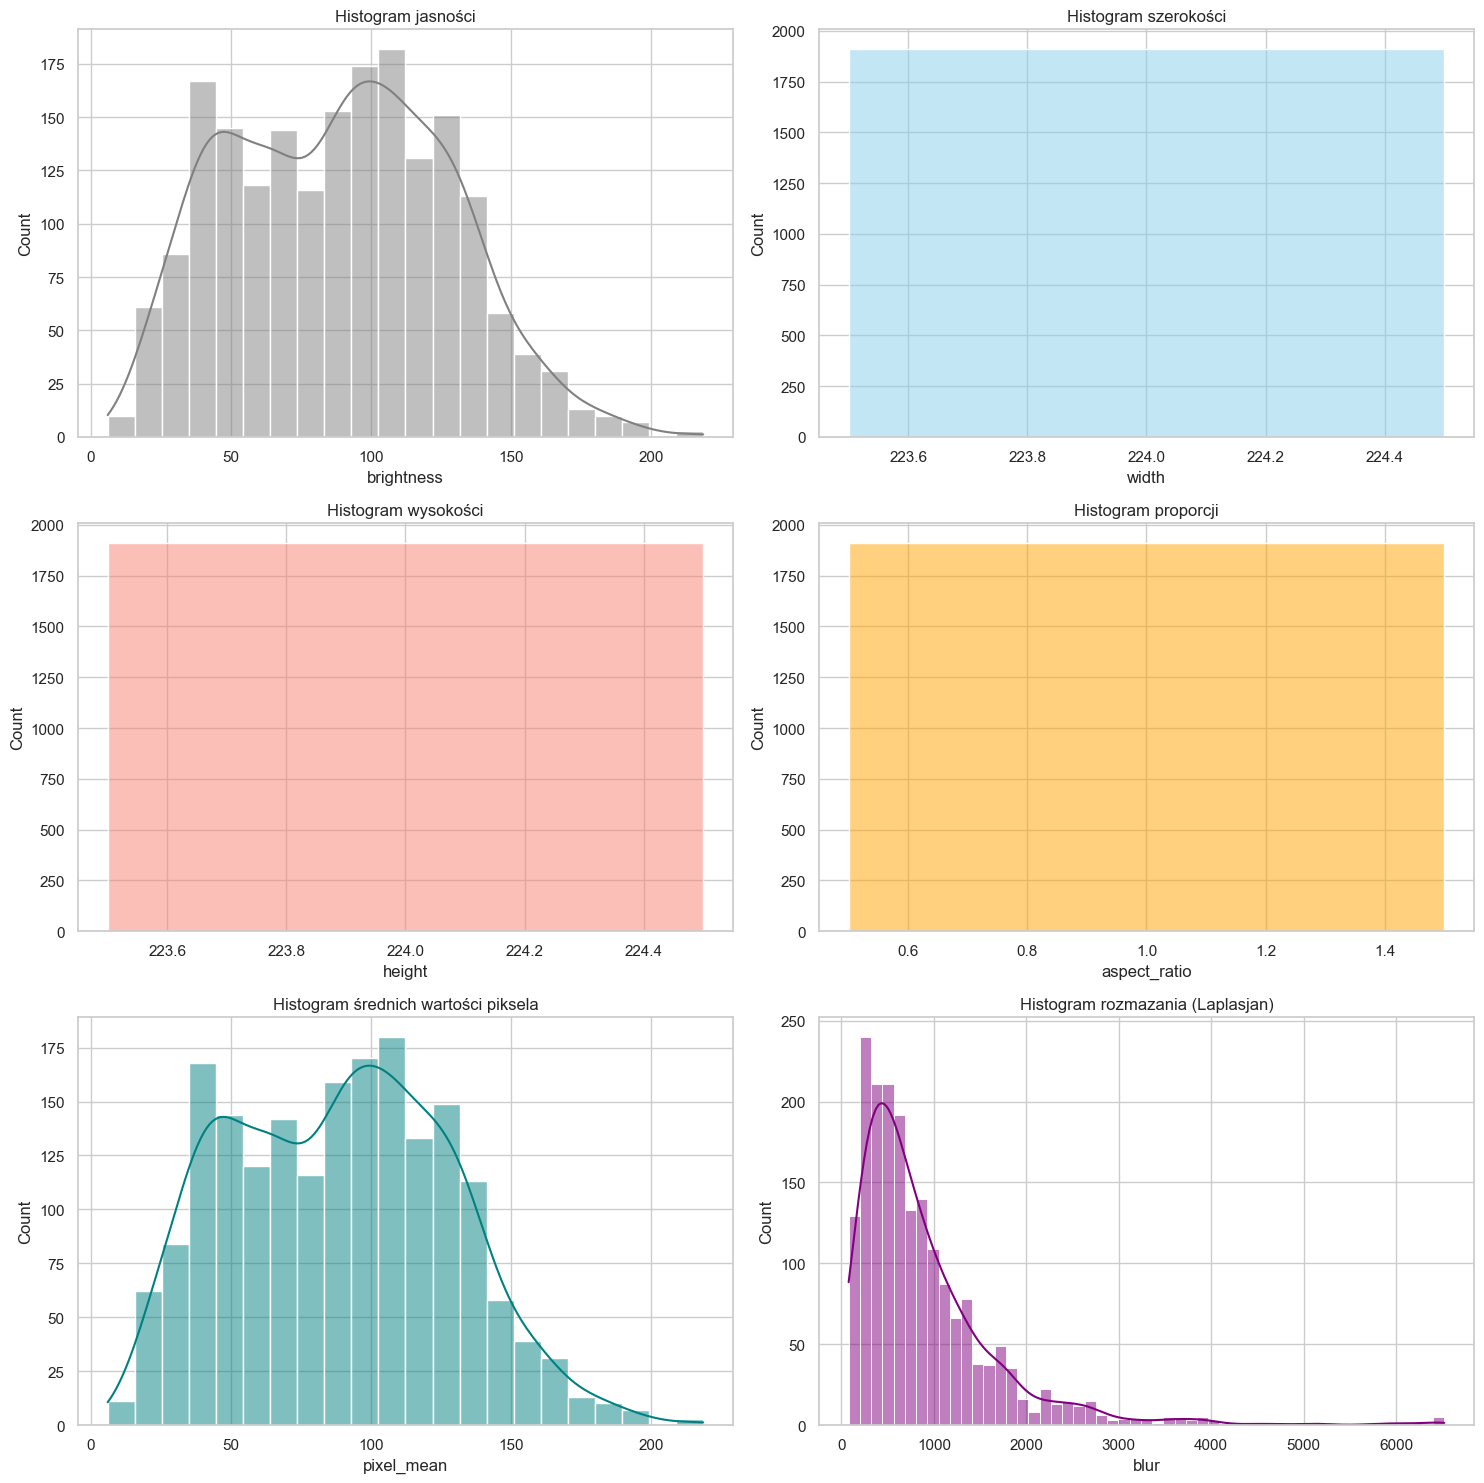

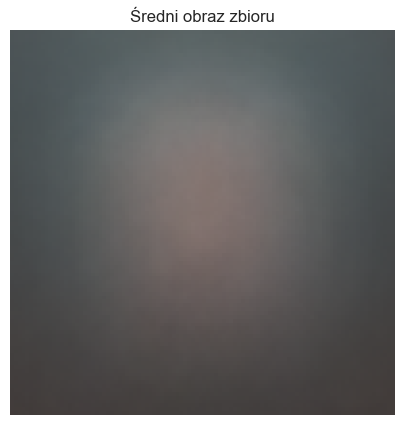

In [ ]:
#Zobrazowanie statystyk zbioru po standaryzacji i resizingu
train_path = 'DATA/Standardized_Resized/Train'
test_path = 'DATA/Standardized_Resized/Test'
valid_path = 'DATA/Standardized_Resized/Valid'

# Zbieramy wszystkie pliki .jpg w podkatalogach dla wszystkich trzech zbiorów
image_paths = glob.glob(os.path.join(train_path, '**', '*.jpg'), recursive=True) + \
              glob.glob(os.path.join(test_path, '**', '*.jpg'), recursive=True) + \
              glob.glob(os.path.join(valid_path, '**', '*.jpg'), recursive=True)

# Inicjalizacja
widths, heights, aspect_ratios = [], [], []
brightness_vals, unique_colors, blur_vals = [], [], []
pixel_means = []
hue_hist_total = np.zeros((180, 1))
avg_image = None

# Przetwarzanie obrazów
for path in tqdm(image_paths, desc="Przetwarzanie obrazów"):
    img = cv2.imread(str(path))
    if img is None:
        print(f"Nie można wczytać obrazu: {path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(w / h)
    brightness_vals.append(np.mean(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)))

    # Średnia wartość piksela (dla RGB razem)
    pixel_means.append(np.mean(img))

    # Histogram Hue
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue_hist_total += cv2.calcHist([hsv], [0], None, [180], [0, 180])

    # Średni obraz (przeskalowany)
    img_resized = cv2.resize(img, (100, 100))
    if avg_image is None:
        avg_image = np.zeros_like(img_resized, dtype=np.float64)
    avg_image += img_resized / len(image_paths)

    # Unikalne kolory
    unique_colors.append(len(np.unique(img_resized.reshape(-1, 3), axis=0)))

    # Rozmazanie
    gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    blur_vals.append(cv2.Laplacian(gray, cv2.CV_64F).var())

# Przekształć średni obraz
avg_image = avg_image.astype(np.uint8)
hue_hist_total /= len(image_paths)

# Tworzymy ramkę danych i statystyki
df = pd.DataFrame({
    'width': widths,
    'height': heights,
    'aspect_ratio': aspect_ratios,
    'brightness': brightness_vals,
    'unique_colors': unique_colors,
    'blur': blur_vals,
    'pixel_mean': pixel_means
})

# Statystyki zbioru
print("📊 Statystyki zbioru (bez podziału na klasy):")
display(df.describe())

# Wykresy
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 6 wykresów = 3x2

sns.histplot(df['brightness'], kde=True, ax=axes[0, 0], color='gray').set_title('Histogram jasności')
sns.histplot(df['width'], kde=True, ax=axes[0, 1], color='skyblue').set_title('Histogram szerokości')
sns.histplot(df['height'], kde=True, ax=axes[1, 0], color='salmon').set_title('Histogram wysokości')
sns.histplot(df['aspect_ratio'], kde=True, ax=axes[1, 1], color='orange').set_title('Histogram proporcji')
sns.histplot(df['pixel_mean'], kde=True, ax=axes[2, 0], color='teal').set_title('Histogram średnich wartości piksela')
sns.histplot(df['blur'], kde=True, ax=axes[2, 1], color='purple').set_title('Histogram rozmazania (Laplasjan)')

plt.tight_layout()
plt.show()

# Średni obraz
plt.figure(figsize=(5, 5))
plt.imshow(avg_image)
plt.title("Średni obraz zbioru")
plt.axis('off')
plt.show()



📁 Przetwarzanie obrazów: (1912 obrazów)


Przetwarzanie obrazów: 100%|██████████| 1912/1912 [00:01<00:00, 1015.64it/s]


Średnia jasność w całym zbiorze: 88.61
Minimalna jasność w zbiorze: 5.93
Maksymalna jasność w zbiorze: 218.60


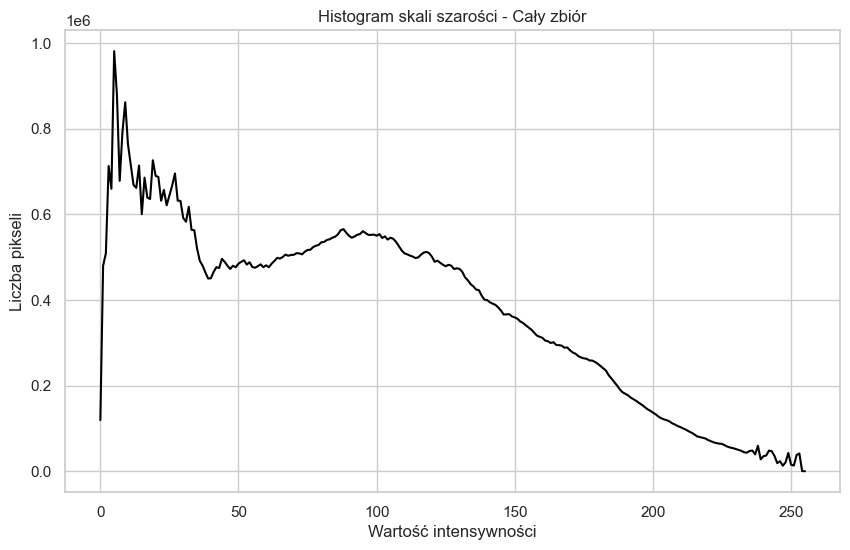

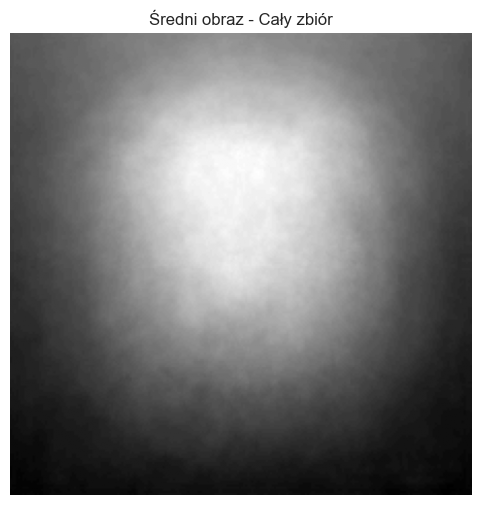

In [12]:
#Skala szarości obrazu to jedna wartość na piksel, która reprezentuje intensywność światła w obrazie, bez informacji o kolorze.

# Ścieżki wejściowe
input_base = Path("DATA/Standardized_Resized")

# Inicjalizacja zmiennych
brightness_vals = []
average_image = None  # Średni obraz dla całego zbioru
gray_hist_total = np.zeros((256, 1))  # Histogram skali szarości (0-255)

# Wyszukaj wszystkie obrazy w katalogu "Standardized" (rekursywnie)
image_paths = list(input_base.rglob("*.jpg"))  # Wyszukaj obrazy .jpg w podkatalogach

print(f"\n📁 Przetwarzanie obrazów: ({len(image_paths)} obrazów)")

# Zmienna do przechowywania minimalnej i maksymalnej jasności
min_brightness = float('inf')
max_brightness = float('-inf')

for img_path in tqdm(image_paths, desc="Przetwarzanie obrazów"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Nie można wczytać: {img_path}")
        continue
    
    # Konwersja do skali szarości
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Obliczanie średniej jasności
    brightness = np.mean(gray_image)
    brightness_vals.append(brightness)

    # Aktualizacja minimalnej i maksymalnej jasności
    min_brightness = min(min_brightness, brightness)
    max_brightness = max(max_brightness, brightness)

    # Histogram skali szarości
    gray_hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    gray_hist_total += gray_hist  # Zbieranie histogramu

    # Obliczanie średniego obrazu
    if average_image is None:
        average_image = np.zeros_like(gray_image, dtype=np.float64)
    average_image += gray_image / len(image_paths)

# Przekształcenie średniego obrazu na uint8
average_image = average_image.astype(np.uint8)

# Wyświetlanie statystyk
print(f"Średnia jasność w całym zbiorze: {np.mean(brightness_vals):.2f}")
print(f"Minimalna jasność w zbiorze: {min_brightness:.2f}")
print(f"Maksymalna jasność w zbiorze: {max_brightness:.2f}")

# Wyświetlanie histogramu skali szarości
plt.figure(figsize=(10, 6))
plt.plot(gray_hist_total, color='black')
plt.title("Histogram skali szarości - Cały zbiór")
plt.xlabel('Wartość intensywności')
plt.ylabel('Liczba pikseli')
plt.show()

# Wyświetlanie średniego obrazu dla całego zbioru
plt.figure(figsize=(6, 6))
plt.imshow(average_image, cmap='gray')
plt.title("Średni obraz - Cały zbiór")
plt.axis('off')
plt.show()

Znaleziono 2229 obrazów.


Przetwarzanie obrazów:   0%|          | 0/2229 [00:00<?, ?it/s]

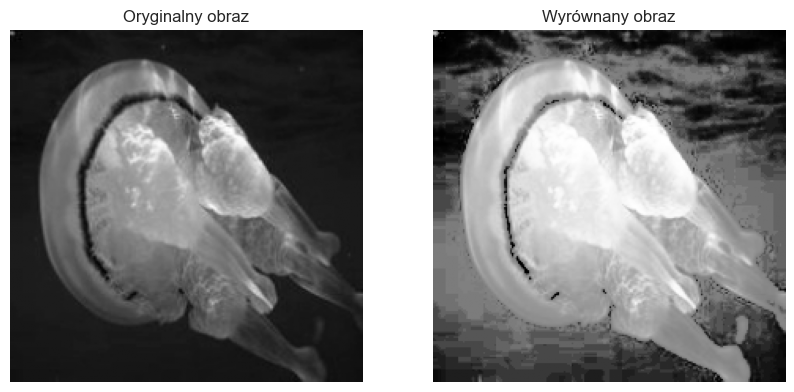

Przetwarzanie obrazów:   0%|          | 1/2229 [00:00<08:49,  4.21it/s]

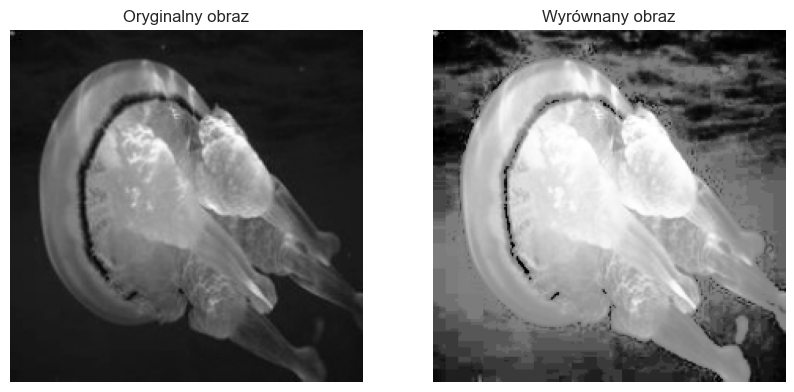

Przetwarzanie obrazów:   0%|          | 2/2229 [00:00<08:30,  4.36it/s]

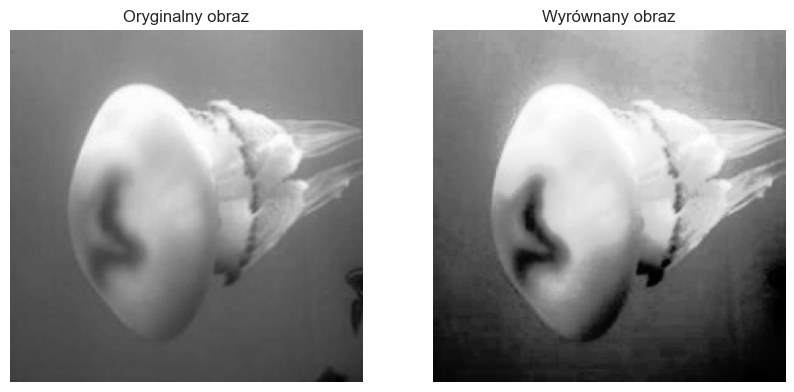

Przetwarzanie obrazów:   0%|          | 3/2229 [00:00<08:42,  4.26it/s]

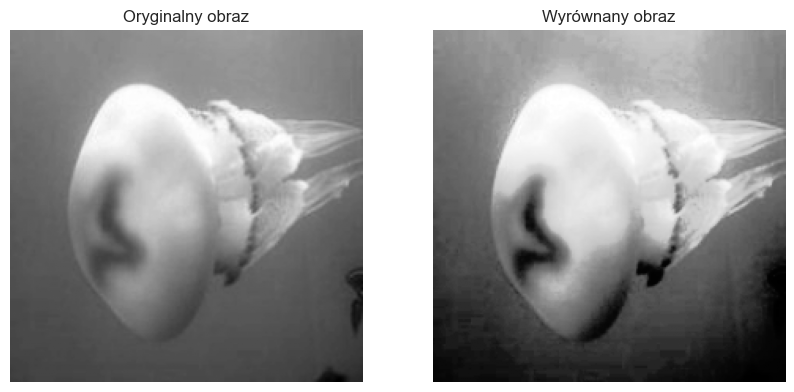

Przetwarzanie obrazów:   0%|          | 4/2229 [00:00<08:56,  4.15it/s]

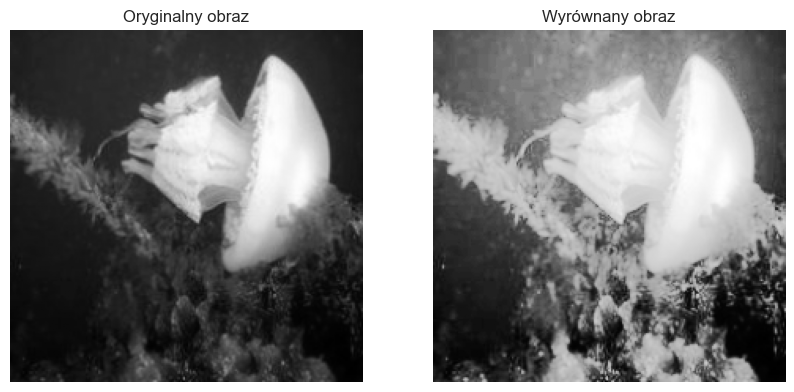

Przetwarzanie obrazów:   0%|          | 5/2229 [00:01<08:54,  4.16it/s]


In [16]:
#Wyrównanie histogramu – poprawi kontrast obrazu i pomoże w rozciągnięciu zakresu jasności, szczególnie w przypadku ciemniejszych obrazów.

from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ścieżka do katalogu z obrazami
input_base = Path("DATA/Standardized_Resized")
image_paths = list(input_base.rglob("*.jpg"))

# Liczba obrazów do wyświetlenia
num_images_to_display = 5

# Sprawdzenie, czy obrazy zostały znalezione
if len(image_paths) == 0:
    print("Brak obrazów w katalogu.")
else:
    print(f"Znaleziono {len(image_paths)} obrazów.")

# Przetwarzanie obrazów (zatrzymujemy się po kilku pierwszych)
for i, img_path in enumerate(tqdm(image_paths, desc="Przetwarzanie obrazów")):
    if i >= num_images_to_display:  # Zatrzymujemy się po określonej liczbie obrazów
        break

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Nie można wczytać: {img_path}")
        continue

    # Konwersja do skali szarości
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Wyrównanie histogramu
    equalized_image = cv2.equalizeHist(gray_image)

    # Zapisanie wyrównanego obrazu
    output_path = img_path.parent / "equalized" / img_path.name
    output_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(output_path), equalized_image)
    
    # Wyświetlanie oryginalnego i wyrównanego obrazu
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(gray_image, cmap='gray')
    plt.title("Oryginalny obraz")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(equalized_image, cmap='gray')
    plt.title("Wyrównany obraz")
    plt.axis('off')

    plt.show()
